In [ ]:
# https://colab.research.google.com/drive/1i9ALh6U-EFHj6P4vZSDD5CBVIDAytRJ-
!gdown --id 1u_lWZPAVIdWG2gsi5myYhdtMoJ3MP0_j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1u_lWZPAVIdWG2gsi5myYhdtMoJ3MP0_j
To: /content/twitter_sentiment_analysis_2cls_dataset.zip
100% 471k/471k [00:00<00:00, 82.9MB/s]


In [ ]:
!unzip /content/twitter_sentiment_analysis_2cls_dataset.zip

Archive:  /content/twitter_sentiment_analysis_2cls_dataset.zip
  inflating: sentiment_analysis.csv  


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [ ]:
dataset_path ='sentiment_analysis.csv'
df = pd.read_csv (
    dataset_path ,
    index_col ='id'
)

In [ ]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


###a) Xây dựng hàm chuẩn hóa văn bản

In [ ]:
def text_normalize ( text ):
    # Retweet old acronym "RT" removal
    text = re.sub (r'^RT[\s]+','', text )

    # Hyperlinks removal
    text = re.sub (r'https ?:\/\/.*[\ r\n]*','', text )

    # Hashtags removal
    text = re.sub (r'#','', text )

    # Punctuation removal
    text = re.sub (r'[^\w\s]','', text )

    # Tokenization
    tokenizer = TweetTokenizer (
        preserve_case =False ,
        strip_handles =True ,
        reduce_len = True
    )
    text_tokens = tokenizer.tokenize ( text )

    return text_tokens

In [ ]:
text = """We love this! Would you go?
#talk #makememories #unplug
 #relax #iphone #smartphone #wifi #connect...
http://fb.me/6N3LsUpCu
"""
text = text_normalize(text)
text

['we',
 'love',
 'this',
 'would',
 'you',
 'go',
 'talk',
 'makememories',
 'unplug',
 'relax',
 'iphone',
 'smartphone',
 'wifi',
 'connect',
 'httpfbme',
 '6n3lsupcu']

###b) Xây dựng bộ lưu giữ tần suất xuất hiện của các từ

In [ ]:
def get_freqs (df):
    freqs = defaultdict( lambda : 0)
    for idx , row in df.iterrows ():
        tweet = row['tweet']
        label = row['label']
        tokens = text_normalize ( tweet )
        for token in tokens :
            pair = (token , label )
            freqs [ pair ] += 1

    return freqs

###c) Xây dựng hàm tạo vector đặc trưng

In [ ]:
def get_feature (text , freqs ):
    tokens = text_normalize ( text )
    X = np. zeros (3)
    X[0] = 1

    for token in tokens :
        X[1] += freqs [( token , 0)]
        X[2] += freqs [( token , 1)]

    return X

###d) Trích xuất đặc trưng toàn bộ dữ liệu:

In [ ]:
X = []
y = []

freqs = get_freqs (df)
for idx , row in df. iterrows ():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature (tweet , freqs )
    X.append(X_i)
    y.append( label )

X = np.array (X)
y = np.array (y)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (7920, 3)
y shape: (7920,)


In [ ]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (
    X, y,
    test_size = val_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

X_train , X_test , y_train , y_test = train_test_split (
    X_train , y_train ,
    test_size = test_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

In [ ]:
normalizer = StandardScaler()
X_train [:, 1:] = normalizer.fit_transform ( X_train [:, 1:])
X_val [:, 1:] = normalizer.transform ( X_val [:, 1:])
X_test [:, 1:] = normalizer.transform ( X_test [:, 1:])

In [ ]:
X_train

array([[ 1.        ,  1.44906749, -0.27188571],
       [ 1.        , -0.54636487, -1.06395169],
       [ 1.        ,  0.6619968 , -0.29561235],
       ...,
       [ 1.        ,  0.39071845,  1.3203234 ],
       [ 1.        ,  1.22008345, -0.08308222],
       [ 1.        ,  0.29720837,  0.37681077]])

In [ ]:
def sigmoid (z):
    return 1 / (1 + np.exp(-z))

def compute_loss (y_hat , y):
    y_hat = np.clip (
        y_hat , 1e-7, 1 - 1e-7
    )
    return (-y * np. log( y_hat ) - (1 - y) * np.log (1 - y_hat )). mean ()

def predict (X, theta ):
    dot_product = np.dot(X, theta )
    y_hat = sigmoid ( dot_product )

    return y_hat

def compute_gradient (X, y, y_hat ):
    return np.dot(
        X.T, ( y_hat - y)
    ) / y. size

def update_theta (theta , gradient , lr):
    return theta - lr * gradient

def compute_accuracy (X, y, theta ):
    y_hat = predict(X, theta ).round()
    acc = ( y_hat == y). mean ()
    return acc

In [ ]:
X = np.array([[22.3, -1.5, 1.1, 1]])
theta = np.array([0.1, -0.15, 0.3, -0.2] )
print(predict(X,theta))
y = np.array([1, 0, 0, 1])
y_hat = np.array([0.8, 0.75, 0.3, 0.95])
print(compute_loss(y_hat,y))

[0.92988994]
0.5043515376900958


In [ ]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed( random_state )
theta = np.random.uniform (
    size = X_train.shape [1]
)

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)
        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.375	Validation loss: 0.370

EPOCH 2:	Training loss: 0.375	Validation loss: 0.370

EPOCH 3:	Training loss: 0.375	Validation loss: 0.370

EPOCH 4:	Training loss: 0.375	Validation loss: 0.370

EPOCH 5:	Training loss: 0.375	Validation loss: 0.370

EPOCH 6:	Training loss: 0.375	Validation loss: 0.370

EPOCH 7:	Training loss: 0.375	Validation loss: 0.370

EPOCH 8:	Training loss: 0.375	Validation loss: 0.370

EPOCH 9:	Training loss: 0.375	Validation loss: 0.370

EPOCH 10:	Training loss: 0.375	Validation loss: 0.370

EPOCH 11:	Training loss: 0.375	Validation loss: 0.370

EPOCH 12:	Training loss: 0.375	Validation loss: 0.370

EPOCH 13:	Training loss: 0.375	Validation loss: 0.370

EPOCH 14:	Training loss: 0.375	Validation loss: 0.370

EPOCH 15:	Training loss: 0.375	Validation loss: 0.370

EPOCH 16:	Training loss: 0.375	Validation loss: 0.370

EPOCH 17:	Training loss: 0.375	Validation loss: 0.370

EPOCH 18:	Training loss: 0.375	Validation loss: 0.370

EPOCH 19:	Training

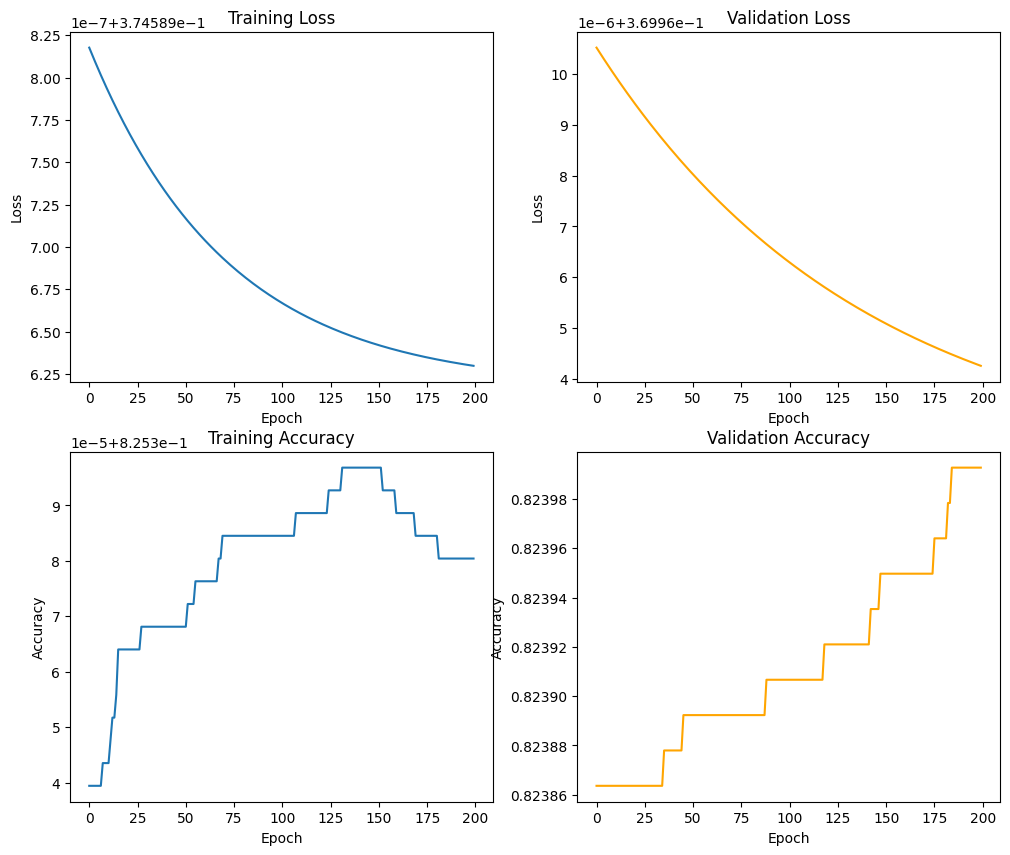

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
# Val set
val_set_acc = compute_accuracy(X_val, y_val, theta)
print('Evaluation on validation set:')
print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.8238636363636364


In [ ]:
# Test set
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on test set:')
print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.8396464646464646
